### Human Detection Using Deeplearning

In [37]:
import torch
from torch import nn
import torchvision
from torchvision import datasets
from torchvision import transforms
from torchvision.transforms import ToTensor
from torch.utils.data import DataLoader
from torchvision.io.image import ImageReadMode
import matplotlib.pyplot as plt
import warnings
warnings.simplefilter(action='ignore', category=UserWarning)

In [2]:
test_data_path = "data\\test"
train_data_path = "data\\train"

* Setting device agnostic code

In [3]:
device = "cuda" if torch.cuda.is_available() else "cpu"

### Transform Data
1. Resize the images to 256x256.
2. Flip images randomly on the horizontal.
3. Turn our images into tensors.

In [4]:
train_transform = transforms.Compose([
    transforms.Resize(size=(256,256)),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.ToTensor()
])

test_transform = transforms.Compose([
    transforms.Resize(size=(256,256)),
    transforms.ToTensor()
])

### Load our images

In [5]:
train_data = datasets.ImageFolder(root=train_data_path, # target folder of images
                                  transform=train_transform, # transforms to perform on data (images)
                                  target_transform=None)

test_data = datasets.ImageFolder(root=test_data_path, # target folder of images
                                  transform=test_transform, # transforms to perform on data (images)
                                  target_transform=None)

In [6]:
class_names = train_data.classes
class_names

['human', 'nonhuman']

### Turning images into DataLoader's

In [7]:
train_dataloader = DataLoader(dataset=train_data,
                              batch_size=1, # how many samples per batch?
                              shuffle=True)

test_dataloader = DataLoader(dataset=test_data,
                              batch_size=1, # how many samples per batch?
                              shuffle=True)

### Create a TinyVGG CNN architecture

The TinyVGG architecture is a smaller and more efficient version of the VGG-16 and VGG-19 convolutional neural networks. TinyVGG has the following key features:

* It uses smaller convolutional filters (3x3 instead of 5x5) and fewer convolutional layers .
* It uses max pooling instead of average pooling.

These changes make TinyVGG significantly smaller and faster than VGG-16 and VGG-19, while still maintaining good accuracy.

In [31]:
class TinyVGG(nn.Module):

    def __init__(self, input_shape: int, hidden_units: int, output_shape: int) -> None:
        super().__init__()
        self.conv_block_1 = nn.Sequential(
            nn.Conv2d(in_channels=input_shape,
                      out_channels=hidden_units,
                      kernel_size=3, # how big is the square that's going over the image?
                      stride=1, # default
                      padding=1), # options = "valid" (no padding) or "same" (output has same shape as input) or int for specific number
            nn.BatchNorm2d(hidden_units),
            nn.ReLU(),
            nn.Conv2d(in_channels=hidden_units,
                      out_channels=hidden_units,
                      kernel_size=3,
                      stride=1,
                      padding=1),
            nn.BatchNorm2d(hidden_units),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2,
                         stride=2) # default stride value is same as kernel_size
        )
        self.conv_block_2 = nn.Sequential(
            nn.Conv2d(hidden_units, hidden_units, kernel_size=3, padding=1),
            nn.BatchNorm2d(hidden_units),
            nn.ReLU(),
            nn.Conv2d(hidden_units, hidden_units, kernel_size=3, padding=1),
            nn.BatchNorm2d(hidden_units),
            nn.ReLU(),
            nn.MaxPool2d(2)
        )
        #self.conv_block_3 = nn.Sequential(
        #    nn.Conv2d(hidden_units, hidden_units, kernel_size=3, padding=1),
        #    nn.BatchNorm2d(hidden_units),
        #    nn.ReLU(),
        #    nn.MaxPool2d(2)
        #)
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(in_features=hidden_units*64*64,
                      out_features=output_shape)
        )

    def forward(self, x: torch.Tensor):
        x = self.conv_block_1(x)
        x = self.conv_block_2(x)
        #x = self.conv_block_3(x)
        x = self.classifier(x)

        return x

### Training & Test Step

In [32]:
def train_step(model: torch.nn.Module,
               dataloader: torch.utils.data.DataLoader,
               loss_fn: torch.nn.Module,
               optimizer: torch.optim.Optimizer):
    # Put model in train mode
    model.train()

    # Setup train loss and train accuracy values
    train_loss, train_acc = 0, 0
    #m = nn.Dropout(p=0.2)

    # Loop through data loader data batches
    for batch, (X, y) in enumerate(dataloader):
        # Send data to target device
        X, y = X.to(device), y.to(device)

        # Forward pass
        y_pred = model(X)

        # Calculate  and accumulate loss
        loss = loss_fn(y_pred, y)
        train_loss += loss.item()

        # Optimizer zero grad
        optimizer.zero_grad()

        # Loss backward
        loss.backward()

        # Optimizer step
        optimizer.step()

        # Calculate and accumulate accuracy metric across all batches
        y_pred_class = torch.argmax(torch.softmax(y_pred, dim=1), dim=1)
        train_acc += (y_pred_class == y).sum().item()/len(y_pred)

    # Adjust metrics to get average loss and accuracy per batch
    train_loss = (train_loss / len(dataloader)) * 100
    train_acc = (train_acc / len(dataloader)) * 100
    return train_loss, train_acc

def test_step(model: torch.nn.Module,
              dataloader: torch.utils.data.DataLoader,
              loss_fn: torch.nn.Module):
    # Put model in eval mode
    model.eval()

    # Setup test loss and test accuracy values
    test_loss, test_acc = 0, 0

    with torch.inference_mode():
        for batch, (X, y) in enumerate(dataloader):

            X, y = X.to(device), y.to(device)

            # Forward pass
            test_pred_logits = model(X)

            # Calculate and accumulate loss
            loss = loss_fn(test_pred_logits, y)
            test_loss += loss.item()

            # Calculate and accumulate accuracy
            test_pred_labels = test_pred_logits.argmax(dim=1)
            test_acc += ((test_pred_labels == y).sum().item()/len(test_pred_labels))

    test_loss = (test_loss / len(dataloader)) * 100
    test_acc = (test_acc / len(dataloader)) * 100

    return test_loss, test_acc

### Train & Test Model

In [33]:
def train(model: torch.nn.Module,
          train_dataloader: torch.utils.data.DataLoader,
          test_dataloader: torch.utils.data.DataLoader,
          optimizer: torch.optim.Optimizer,
          loss_fn: torch.nn.Module = nn.CrossEntropyLoss(),
          epochs: int = 5):


    results = {"train_loss": [],
        "train_acc": [],
        "test_loss": [],
        "test_acc": []
    }

    # Loop through training and testing steps for a number of epochs
    for epoch in range(epochs):
        train_loss, train_acc = train_step(model=model,
                                           dataloader=train_dataloader,
                                           loss_fn=loss_fn,
                                           optimizer=optimizer)
        test_loss, test_acc = test_step(model=model,
                                        dataloader=test_dataloader,
                                        loss_fn=loss_fn)


        print(
            f"Epoch: {epoch+1} | "
            f"train_loss: {train_loss:.2f}% | "
            f"train_acc: {train_acc:.2f}% | "
            f"test_loss: {test_loss:.2f}% | "
            f"test_acc: {test_acc:.2f}%"
        )


        results["train_loss"].append(train_loss)
        results["train_acc"].append(train_acc)
        results["test_loss"].append(test_loss)
        results["test_acc"].append(test_acc)

    return results


### Initialize the model, loss function and optimizer

1. loss function(Cross-entropy loss)

  * Cross-entropy loss is a loss function used in machine learning to measure the performance of a classification model.
  * It measures the difference between the predicted probability distribution of a machine learning classification model and the true probability distribution.

In [35]:
torch.manual_seed(42)
torch.cuda.manual_seed(42)

# Set number of epochs
NUM_EPOCHS = 16

model_0 = TinyVGG(input_shape=3, # number of color channels
                  hidden_units=8,
                  output_shape=len(train_data.classes)).to(device)

loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(params=model_0.parameters(), lr=0.001)



### Train Model

In [36]:
model_0_results = train(model=model_0,
                        train_dataloader=train_dataloader,
                        test_dataloader=test_dataloader,
                        optimizer=optimizer,
                        loss_fn=loss_fn,
                        epochs=NUM_EPOCHS)

Epoch: 1 | train_loss: 242.5188 | train_acc: 59.6730 | test_loss: 72.8758 | test_acc: 58.8235
Epoch: 2 | train_loss: 68.4301 | train_acc: 66.8937 | test_loss: 84.1344 | test_acc: 50.2674
Epoch: 3 | train_loss: 53.4334 | train_acc: 74.2507 | test_loss: 76.6730 | test_acc: 56.6845
Epoch: 4 | train_loss: 50.4922 | train_acc: 77.1117 | test_loss: 87.1322 | test_acc: 55.0802
Epoch: 5 | train_loss: 44.0521 | train_acc: 79.9728 | test_loss: 74.5628 | test_acc: 59.3583
Epoch: 6 | train_loss: 44.0470 | train_acc: 82.1526 | test_loss: 74.5398 | test_acc: 56.6845
Epoch: 7 | train_loss: 35.1206 | train_acc: 85.8311 | test_loss: 104.7344 | test_acc: 57.2193
Epoch: 8 | train_loss: 33.6877 | train_acc: 87.7384 | test_loss: 136.2298 | test_acc: 58.8235
Epoch: 9 | train_loss: 25.0357 | train_acc: 90.8719 | test_loss: 155.7790 | test_acc: 57.2193
Epoch: 10 | train_loss: 25.7947 | train_acc: 90.7357 | test_loss: 140.1927 | test_acc: 59.8930
Epoch: 11 | train_loss: 20.3195 | train_acc: 93.5967 | test_loss

# Plotting Loss Curves

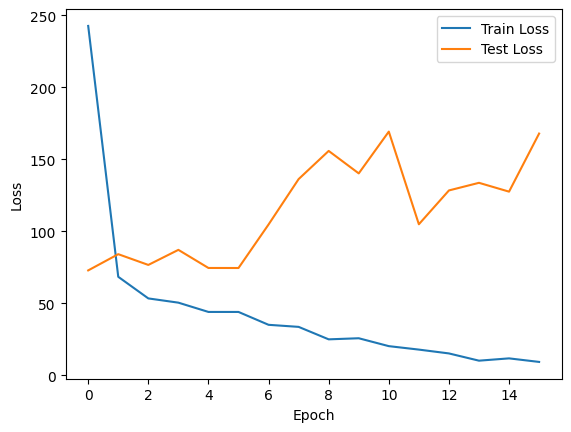

In [40]:
plt.plot(range(NUM_EPOCHS),model_0_results["train_loss"])
plt.plot(range(NUM_EPOCHS),model_0_results["test_loss"])
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(["Train Loss", "Test Loss"])
plt.show()

## Testing model on custom data

In [55]:
#custom_image_path = "data\Sample-Image-captured-by-CCTV-camera.png"
custom_image_path = "data\\2015-04-02_18_21.JPG"

custom_image = torchvision.io.read_image(str(custom_image_path), mode=ImageReadMode.RGB).type(torch.float32)

#Divide the image pixel values by 255 to get them between [0, 1]
custom_image = custom_image / 255
custom_image_transform = transforms.Compose([
    transforms.Resize((256, 256)),
])

# Transform target image
custom_image_transformed = custom_image_transform(custom_image)

model_0.eval()
with torch.inference_mode():
    custom_image_transformed_with_batch_size = custom_image_transformed.unsqueeze(dim=0)
    custom_image_pred = model_0(custom_image_transformed.unsqueeze(dim=0).to(device))

custom_image_pred_probs = torch.softmax(custom_image_pred, dim=1)
custom_image_pred_label = torch.argmax(custom_image_pred_probs, dim=1)
custom_image_pred_class = class_names[custom_image_pred_label.cpu()]

print(custom_image_pred_class)

human
